In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from bpf import bpf
import tensorflow as tf
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.layers import Dense
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [36]:
sr = 4
data = pd.read_csv('FEATURES_PHI_WELL01.csv').values
x_train = data[:,0:5]
y_train = data[:,-1]

# Creating ANN Architecture
lrelu = lambda x: tf.keras.activations.relu(x, alpha=2.5)  #change alpha to control amplitude , BERBANDING LURUS, semakin besar kurang resolve value kecil
model = Sequential()  # intializer
model.add(Dense(48, input_dim=x_train.shape[1], kernel_initializer='glorot_uniform',bias_initializer='glorot_uniform',activation='linear', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001)))  # input layer
model.add(Dense(24, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='linear',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001)))  # 1st hidden layer
model.add(Dense(12, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='linear',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001)))  # 1st hidden layer
model.add(Dense(6, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='linear',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001)))  # 1st hidden layer
model.add(Dense(3, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='linear',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001)))  # 2nd hidden layer
model.add(Dense(1, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='linear',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001)))  # output layer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])  # Compiling the ANN
model.summary()
model.fit(x_train, y_train, batch_size=12, epochs=20, verbose=1, validation_split=0.35)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 48)                288       
                                                                 
 dense_7 (Dense)             (None, 24)                1176      
                                                                 
 dense_8 (Dense)             (None, 12)                300       
                                                                 
 dense_9 (Dense)             (None, 6)                 78        
                                                                 
 dense_10 (Dense)            (None, 3)                 21        
                                                                 
 dense_11 (Dense)            (None, 1)                 4         
                                                                 
Total params: 1,867
Trainable params: 1,867
Non-traina

12/12 [==============================] - 0s 4ms/step


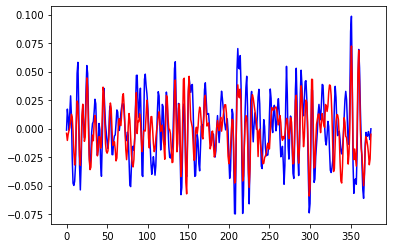

32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 5ms/step


In [37]:

# PREDICT USING MODEL
vs_pred = model.predict(x_train)
plt.plot(y_train,'b')
plt.plot(vs_pred,'r')
plt.show()


xlineke=154
wellphi = pd.read_csv('PHIE.csv').values
PHIE = wellphi[:,1]
TLIM = wellphi[:,0]

attr1 = np.load('data/NEARS.npy')
attr2 = np.load('data/MIDS.npy')
attr3 = np.load('data/A.npy')
attr4 = np.load('data/B.npy')
attr5 = np.load('data/APLUSB.npy')

hasil = []
for i in range(attr1.shape[1]):
    x_test1= attr1[:,i]
    x_test2= attr2[:,i]
    x_test3= attr3[:,i]
    x_test4= attr4[:,i]
    x_test5= attr5[:,i]
    vs_pred = model.predict(np.vstack((x_test1,x_test2,x_test3,x_test4,x_test5)).T)
    hasil.append(vs_pred)

hasil = np.asarray(hasil).T
traces = hasil[0, :, :]
traces= bpf(traces,5,45,sr)

np.save('traces', traces)

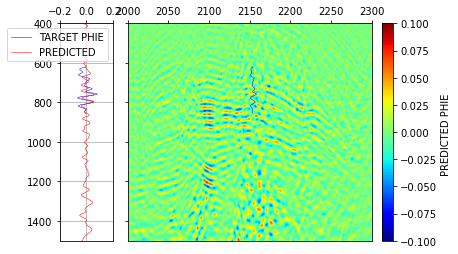

In [44]:
traces = np.load('traces.npy')
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 5]},sharey=True)
fig.subplots_adjust(wspace=0.093)
ax0.xaxis.set_ticks_position('top')
ax0.xaxis.set_label_position('top')
ax0.plot(PHIE, TLIM,'b', label='TARGET PHIE', linewidth=0.5)
ax0.plot(traces[:,xlineke], np.arange(0,len(traces[:,xlineke]),1)*sr,'r', label='PREDICTED', linewidth=0.5)
ax0.set_xlim(-0.2,0.2)
ax0.set_ylim(1500,400)
ax0.grid()
ax0.legend(loc = 'upper right')

XLWELL=2154
XLINES = [2000, 2300]
im = ax1.imshow(traces, aspect='auto', interpolation='bilinear', vmin=-0.1, vmax =0.1, cmap='jet',extent=[XLINES[0],XLINES[-1],traces.shape[0]*sr,0])
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('PREDICTED PHIE ')
ax1.plot(50*PHIE+XLWELL, TLIM, linewidth = '0.5', color='b')

f = interpolate.interp1d(TLIM, PHIE)
TLIM = np.arange(min(TLIM),max(TLIM),0.5)
PHIE = f(TLIM)
ax1.scatter(PHIE*0+XLWELL, TLIM, c=PHIE, marker='s', s=10, cmap='jet', vmin=-0.2, vmax =0.2, edgecolor='none')

ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_label_coords(0, 1.015)
ax1.set_ylim(1500,400)

plt.show()